# Imports

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Image Transformations

In [2]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize like ImageNet
])

In [3]:
# For test data, we only resize & normalize (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Dataset

In [5]:
# Define paths
train_dir = "dataset/train"
test_dir = "dataset/test"

# Load dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [6]:
# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [7]:
print(train_dataset.classes)

['Apple___alternaria_leaf_spot', 'Apple___black_rot', 'Apple___brown_spot', 'Apple___gray_spot', 'Apple___healthy', 'Apple___rust', 'Apple___scab', 'Bell_pepper___bacterial_spot', 'Bell_pepper___healthy', 'Blueberry___healthy', 'Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease', 'Cherry___healthy', 'Cherry___powdery_mildew', 'Coffee___healthy', 'Coffee___red_spider_mite', 'Coffee___rust', 'Corn___common_rust', 'Corn___gray_leaf_spot', 'Corn___healthy', 'Corn___northern_leaf_blight', 'Grape___Leaf_blight', 'Grape___black_measles', 'Grape___black_rot', 'Grape___healthy', 'Orange___citrus_greening', 'Peach___bacterial_spot', 'Peach___healthy', 'Potato___bacterial_wilt', 'Potato___early_blight', 'Potato___healthy', 'Potato___late_blight', 'Potato___leafroll_virus', 'Potato___mosaic_virus', 'Potato___nematode', 'Potato___pests', 'Potato___phytophthora', 'Raspberry___healthy', 'Rice___bacterial_blight', 'R

# Sample Visualization 

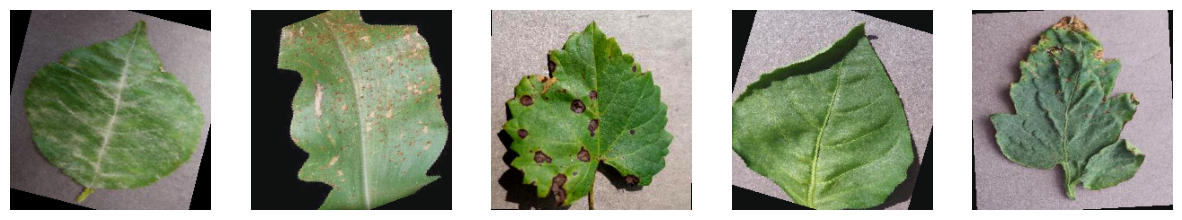

In [8]:
def imshow(ax, img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img * std + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Keep values in range
    ax.imshow(img)
    ax.axis("off")

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    imshow(axes[i], images[i])  # Pass subplot axis to the function

plt.show()


# Training MobileNetV2(Pre-Trained)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import os

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to save the model
pretrained_model_path = "mobilenetv2_pretrained.pth"

# Number of classes in your dataset
num_classes = len(train_dataset.classes)

In [11]:
if os.path.exists(pretrained_model_path):
    print("Loading saved pretrained model...")
    mobilenet_v2 = models.mobilenet_v2(weights=None)
    mobilenet_v2.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    mobilenet_v2.load_state_dict(torch.load(pretrained_model_path))
    mobilenet_v2.eval()  # Set to evaluation mode
    mobilenet_v2 = mobilenet_v2.to(device)
    print("Pretrained model loaded successfully!")

else:
    print("No saved model found. Initializing MobileNetV2 with pretrained weights...")
    mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    
    # Freeze base layers (optional)
    for param in mobilenet_v2.features.parameters():
        param.requires_grad = False

    # Modify the classifier for our dataset
    mobilenet_v2.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

    # Move model to device
    mobilenet_v2 = mobilenet_v2.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


Loading saved pretrained model...


C:\Users\RJ\AppData\Local\Temp\ipykernel_340\1300130251.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mobilenet_v2.load_state_dict(torch.load(pretrained_model_path))


Pretrained model loaded successfully!


## Training 

In [ ]:
from tqdm import tqdm

num_epochs = 2  # Faster training with pretrained weights

for epoch in range(num_epochs):
    mobilenet_v2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet_v2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Train Acc: {train_acc:.2f}%")

    scheduler.step()


In [ ]:
import time
import torch
from tqdm import tqdm
from torch.amp import autocast, GradScaler  # <- NEW import for PyTorch 2.5+

num_epochs = 2
scaler = GradScaler(device='cuda')  # <- NEW recommended syntax

for epoch in range(num_epochs):
    mobilenet_v2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type='cuda'):  # <- NEW syntax
            outputs = mobilenet_v2(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        with torch.no_grad():
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Train Acc: {train_acc:.2f}%")

    scheduler.step()


## Testing 

In [20]:
# Switch to evaluation mode
mobilenet_v2.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print final accuracy
test_acc = 100 * correct / total
print(f"Test Accuracy of MobileNetV2 (trained from scratch): {test_acc:.2f}%")


100%|████████████████████████████████████████████████████████████████████████████████| 727/727 [06:49<00:00,  1.78it/s]

Test Accuracy of MobileNetV2 (trained from scratch): 88.98%


In [ ]:
model_path = "mobilenetv2_pretrained.pth"
# Save the trained model
torch.save(mobilenet_v2.state_dict(), pretrained_model_path)
print("Pretrained MobileNetV2 model saved successfully!")